In [1]:
import jax
import numpy as np
import jax.numpy as jnp
from functools import partial
from jax import jacfwd, jacrev
import matplotlib.pyplot as plt
import jax.scipy.linalg as jlinalg

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_platform_name', 'cpu')

from parsmooth import MVNStandard
from parsmooth import FunctionalModel
from parsmooth.sequential._filtering import filtering
from parsmooth.linearization import extended, extended_hessian
from parsmooth.sequential._filtering_Newton import filtering as newton_filtering
from parsmooth.sequential._smoothing_Newton import smoothing as newton_smoothing

In [2]:
def dynamic_model(xk):
    return jnp.tanh(xk)
def measurement_model(xk):
    return jnp.sin(xk)

In [3]:
# Get data
T = 60
xs = np.zeros((T, 1))
ys = np.zeros((T, 1))
sigma = 0.1
x0 = np.random.normal(loc=0, scale=1)
x = x0
xs[0] = x
for k in range(T):
    q = np.random.normal(loc=0, scale=sigma)
    r = np.random.normal(loc=0, scale=sigma)
    x = dynamic_model(x) + q
    y = measurement_model(x) + r
    xs[k] = x
    ys[k] = y

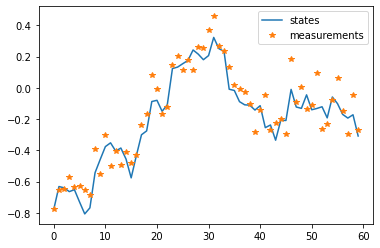

In [4]:
plt.figure()
plt.plot(xs)
plt.plot(ys, '*')
plt.legend(['states', 'measurements']);

## Sequential solution

In [5]:
Q = jnp.array([[sigma**2]])
R = jnp.array([[sigma**2]])
initial_states =  MVNStandard(jnp.repeat(jnp.array([[3.]]),T + 1, axis=0),
                                                     jnp.repeat(jnp.eye(1).reshape(1, 1, 1), T + 1, axis=0))
transition_model = FunctionalModel(partial(dynamic_model), MVNStandard(jnp.zeros((1,)), Q))
observation_model = FunctionalModel(partial(measurement_model), MVNStandard(jnp.zeros((1,)), R))

In [6]:
# Filtering - Gauss-Newton
m0 = dynamic_model(xs[0])
P0 = Q
init = MVNStandard(m0, P0)

xf = filtering(ys, init, transition_model, observation_model, extended, initial_states)


In [7]:
# Filtering - Newton
filtered_states_newton = newton_filtering(ys, init, transition_model, observation_model, extended_hessian, initial_states, False)

In [8]:
# Smoothing - Newton
smoothed_states_newton = newton_smoothing(transition_model, filtered_states_newton,  extended, initial_states)

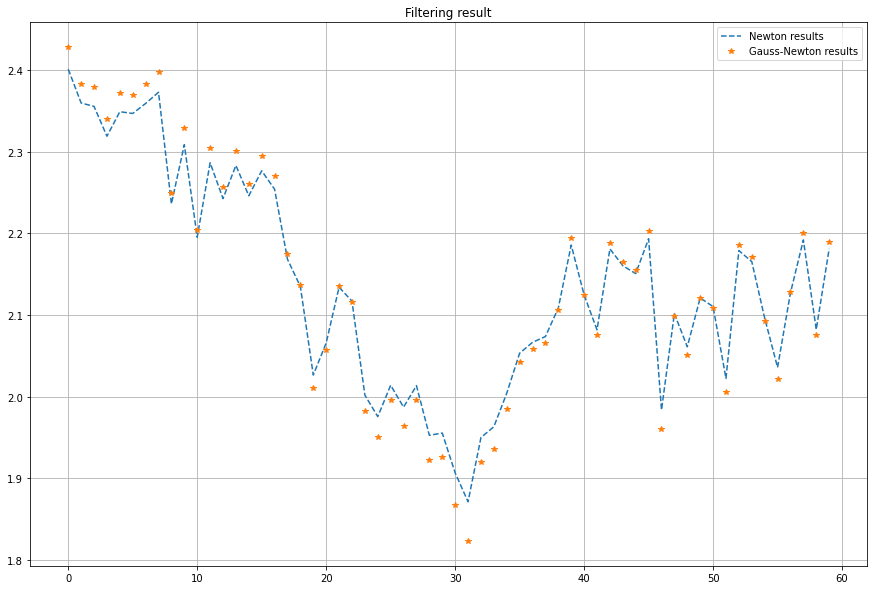

In [9]:
plt.figure(figsize=(15,10))
plt.plot(filtered_states_newton.mean[1:], "--", label="Newton results" )
plt.plot(xf.mean[1:], "*", label = "Gauss-Newton results")
plt.title("Filtering result")
plt.grid()
plt.legend();

# Batch solution

In [10]:
def mvn_loglikelihood(x, chol_cov):
    """multivariate normal"""
    dim = chol_cov.shape[0]
    y = jlinalg.solve_triangular(chol_cov, x, lower=True)
    normalizing_constant = (
            jnp.sum(jnp.log(jnp.abs(jnp.diag(chol_cov)))) + dim * jnp.log(2 * jnp.pi) / 2.0
    )
    norm_y = jnp.sum(y * y, -1)
    return -0.5 * norm_y - normalizing_constant

### Compute gradient and the full hessian

In [11]:
def LL(predict_trajectory, update_trajectory, z, measurement_fun, dynamic_fun, chol_Q, chol_R):
    mp_nominal = predict_trajectory
    mu_nominal = update_trajectory
    cost = mvn_loglikelihood(mu_nominal - dynamic_fun(mp_nominal), chol_Q) + mvn_loglikelihood(z - measurement_fun(mu_nominal), chol_R)
    return -cost

def lost_function(x):
    x0 = x[0]
    predict_traj =x[:-1]
    update_traj = x[1:]
    vmapped_fun = jax.vmap(LL, in_axes=[0, 0, 0, None, None, None, None])
    return jnp.sum(vmapped_fun(predict_traj, update_traj, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R))) - mvn_loglikelihood(x0 - m0, jnp.linalg.cholesky(P0))

grad = jax.grad(lost_function, argnums=0)(initial_states.mean)
Hess = jacfwd(jacrev(lost_function))(initial_states.mean)

In [12]:
x_batch = initial_states.mean - jax.numpy.linalg.tensorsolve(Hess, grad)

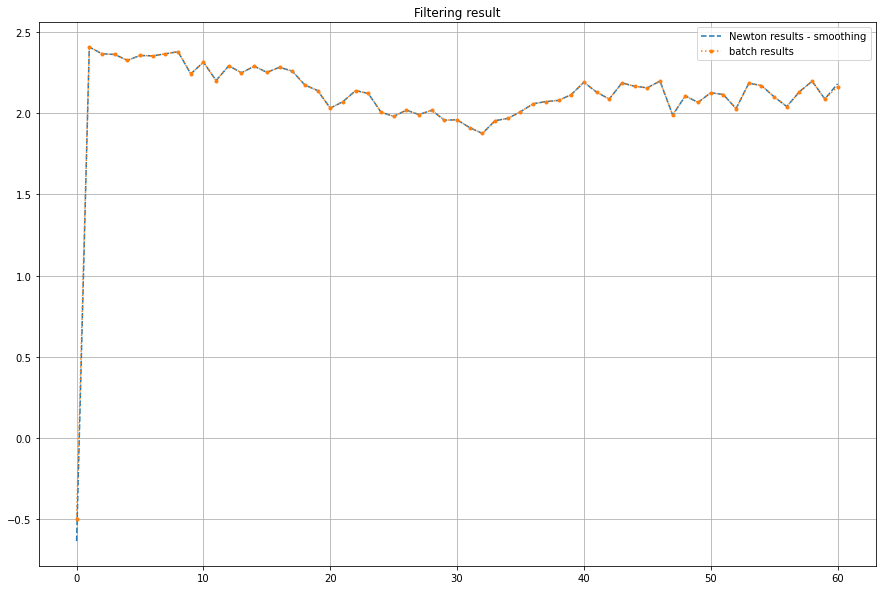

In [13]:
plt.figure(figsize=(15,10))
plt.plot(smoothed_states_newton.mean, "--", label="Newton results - smoothing" )
# plt.plot(xf.mean, "*", label = "Gauss-Newton results")
plt.plot(x_batch, ".:", label = "batch results")
plt.title("Filtering result")
plt.grid()
plt.legend();

In [14]:
np.testing.assert_allclose(smoothed_states_newton.mean[1:-2], x_batch[1:-2], atol=1e-3, rtol=1e-3)

### Compute gradient and non-zero elements of hessian

In [15]:
# cost at step 0
def ell_first(x_k_0):
    return  - mvn_loglikelihood(x_k_0 - m0, jnp.linalg.cholesky(P0))

# cost at step k
def ell(x_k, x_k_m_1, z_k, measurement_fun, dynamic_fun, chol_Q, chol_R):
    prior = mvn_loglikelihood(x_k - dynamic_fun(x_k_m_1), chol_Q)
    log_pdf = mvn_loglikelihood(z_k - measurement_fun(x_k), chol_R)
    return -prior - log_pdf

# The whole cost
def L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    xs_k, xs_k_m_1 = traj[1:], traj[:-1]
    vmap_ell = jax.vmap(ell, (0, 0, 0, None, None, None, None))
    ells = vmap_ell(xs_k, xs_k_m_1, obs, measurement_fun, dynamic_fun, chol_Q, chol_R)
    return jnp.sum(ells) + ell_first(traj[0])

# gradient
def grad_L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    return jax.grad(L)(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R)

# hessian
def hess_L(traj, obs, measurement_fun, dynamic_fun, chol_Q, chol_R):
    def hess_util(x_k, x_k_p_1, x_k_m_1, z_k, z_k_p_1):
        one = ell(x_k, x_k_m_1, z_k, measurement_fun, dynamic_fun, chol_Q, chol_R)
        two = ell(x_k_p_1, x_k, z_k_p_1, measurement_fun, dynamic_fun, chol_Q, chol_R)
        return one + two

    hess_diag_fn = jax.vmap(jax.jacfwd(jax.jacrev(hess_util)), (0, 0, 0, 0, 0))

    hess_diag =  hess_diag_fn(traj[1:-1], traj[2:], traj[:-2], obs[:-1], obs[1:])

    hess_off_diag_fn = jax.vmap(jax.jacfwd(jax.jacrev(hess_util, argnums=1)), (0, 0, 0, 0, 0))
    hess_off_diag =  hess_off_diag_fn(traj[1:-1], traj[2:], traj[:-2], obs[:-1], obs[1:])
    return hess_diag, hess_off_diag



In [16]:
grad_L(initial_states.mean, ys, measurement_model, dynamic_model, jnp.linalg.cholesky(Q), jnp.linalg.cholesky(R));